In [4]:
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import dgl
from GraphSage import GraphSageNet
import time
import os
import wandb
import time
from tqdm import tqdm
import argparse
import yaml
import sys
sys.path.append('../preprocessing')


from utils import *
# from mit_semseg.utils import AverageMeter, colorEncode, accuracy, intersectionAndUnion
import glob
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from skimage.io import imread
# import sys
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from skimage.segmentation import slic, mark_boundaries
from skimage.io import imsave
import os
import torch
warnings.filterwarnings(action='ignore')
from dgl.data.utils import load_graphs


class Tester(object):
    def __init__(self, config):
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        config['device'] = self.device
        self.batch_size = config['training']['batch_size']
        self.train_id =  config['test']['train_id']
        
        self.model_path = os.path.join(config['test']['ckpt_dir'] ,'ckpt_'+str(self.train_id),config['test']['ckpt_file'])
        self.save_dir = os.path.join(config['test']['save_result_dir']);   os.makedirs(self.save_dir, exist_ok = True)
        
        self.n_class = config['training']['n_classes']
        self.sampler = config['sampler']['sampler_true']
        self.sampler_neighbor = config['sampler']['sampler_neighbor']
        config['batch_norm'] = 'bn'
        # self.test_data= data_test_generator(config)
        # multi_scale mode
        self.multi_scale = config['multi_scale_mode']['use_multi_scale']
        if self.sampler : 
            self.model = GraphSageNet_sampler(config).to(self.device)
        elif self.multi_scale : 
            self.model = GraphMultiNet(config).to(self.device)
        # elif config['test_mode']:
        #     self.model = GNN(config).to(self.device)
        else : 
            self.model = GraphSageNet(config).to(self.device)
        # self.model = torch.nn.DataParallel(self.model)
        self.result_name = 'result'+'_'+str(self.train_id)
        
        
    def test(self):
        self.model.load_state_dict(torch.load(self.model_path,map_location=self.device),strict=False)
        self.model.eval()
        torch.cuda.empty_cache()
        print('dataloading...')
        # glist, label_dict = load_graphs(self.pickle_dir+self.pickle_name.replace('pickle','bin'))    
        # self.raw_data=glist
        self.raw_data = pd.read_pickle(os.path.join(self.config['data']['pickle_dir'], self.config['test']['test_pickle_name']))  
        with torch.no_grad(): 
            
            
            print('Test...')
            test_acc = []
            save_test_result = []
            
            for idx, row in tqdm(self.raw_data.iterrows()):
                spixel= row['superpixel_segment']
                # ../data/city/img/train/krefeld/krefeld_000000_020624_leftImg8bit.png
                id_path = row['id']
                gt_path = id_path.replace('img','gt').replace('leftImg8bit','gtFine_labelIds')
                G = row['G']
                feature = row['feature']
                feature[:,:3] = feature[:,:3] / 255 # rgb normalization
                edges = row['edges']
                label_gt = row['label_gt']
                num_nodes = len(label_gt)
                edges_src = torch.tensor(edges[:,0])
                edges_dst = torch.tensor(edges[:,1])
                dgel_graph = dgl.graph((edges_src , edges_dst), num_nodes=num_nodes, idtype=torch.int32)
                dgel_graph.ndata['feat'] = torch.from_numpy(feature)
                dgel_graph.ndata['label'] = torch.from_numpy(np.array(label_gt))
                dgel_graph = dgl.remove_self_loop(dgel_graph)
                dgel_graph = dgl.add_self_loop(dgel_graph)
                

                feature_test  = dgel_graph.ndata['feat'].to(self.device)
                label_test = dgel_graph.ndata['label'].to(self.device)
                G_test = dgel_graph.to(self.device)
                output_test = self.model(G_test, feature_test) 
                label_test_onehot = F.one_hot(label_test.to(torch.int64), self.n_class) 
                label_test = torch.max(label_test_onehot, 1)[1]
    
                # calculate accuracy
                
                pred = output_test.argmax(dim=1, keepdim=True)
                 
                # pred = output_test.argmax(dim=1, keepdim=True)
                crr = pred.eq(label_test.view_as(pred)).sum().item()
                acc = crr / len(pred)
                test_acc.append(acc)
                feature_test = feature_test.cpu().numpy()
                label_test = label_test.cpu().numpy()
                
                # output_test = output_test.cpu().numpy()
                # label_test = label_test.cpu().numpy()
                pred = pred.cpu().numpy()
                
                # save_test_result.append([spixel, gt_path, feature_test,label_test,G,output_test,label_gt,pred])
                save_test_result.append([spixel, gt_path, label_test,pred])
            
            print("validation acc : {:.6f}".format( np.mean(test_acc) ))
            pred = pd.DataFrame(save_test_result)
            # df.columns = ['spixel','gt_path','feature_test','label_test','G','output_test','label_gt','pred']
            pred.columns = ['spixel','gt_path','label_test','pred']
            
            print('Save Dataframe...')
            pred.to_pickle(os.path.join(self.save_dir,self.result_name + '.pickle'))
            
            print("Save Images....")
            
            #### eval part
            # num = pred_pickle_path.split('/')[1].split('_')[1].split('.')[0]
            save_path = f'convert_test_set/pred_g2i_{self.train_id}/'
            os.makedirs(save_path,exist_ok=True)
            convert_Graph_to_Image_function(save_path, pred,self.device)
            pred_path = save_path
            
            
            return pred_path
    
def convert_Graph_to_Image_function(save_path, df,device):
    
    for px in tqdm(range(len(df))):
        
        row = df.iloc[px]
        name_path = row['gt_path']
        name = name_path.split('/')
        
        save_name_pred = save_path + name[4] + '_' + name[-1].split('.')[0]
        # print(save_name_pred)
        
        G2_img = np.zeros((row['spixel'].shape[0], row['spixel'].shape[1]))
        

        G2_img = torch.from_numpy(G2_img)
        G2_img = G2_img.to(torch.device(device))
        
        prediction_cl = np.array(row['pred'])
        test_cl = np.array(row['label_test'])
        superpixel_img = np.array(row['spixel'])
        
        node_num = np.amax(superpixel_img)
                           
        prediction_cl = torch.from_numpy(prediction_cl)
        prediction_cl = prediction_cl.to(torch.device(device))
        
        test_cl = torch.from_numpy(test_cl)
        test_cl = test_cl.to(torch.device(device))
    
        superpixel_img = torch.from_numpy(superpixel_img)
        superpixel_img = superpixel_img.to(torch.device(device))

        for ix in range(node_num):
            
            superpixel_cluster = (superpixel_img[:,:] == ix)
            
            
            prediction_superpixel_cluster_node_mapping = torch.multiply(superpixel_cluster, prediction_cl[ix])
            
            
            
            G2_img = torch.add(G2_img, prediction_superpixel_cluster_node_mapping)
            
        
        G2_img = G2_img.cpu().numpy()
        
        
        np.save(save_name_pred, G2_img)
        # imsave(save_name_pred, G2_img)
        
    

def parse(path):
    with open(path, 'r') as f:
        config = yaml.safe_load(f)
        f.close()
    return config

In [5]:
now = int(time.time())

config_path = f'yml/train_uav.yaml'
config = parse(config_path)
# os.environ['CUDA_VISIBLE_DEVICES']=str(config['training']['gpu']['id'] )    
os.environ['CUDA_VISIBLE_DEVICES']='3'



try :
    wandb_name = config['test']['wandb_name']
    wandb_names = wandb_name.split('_')
    config['hidden_dim'] = int(wandb_names[4])
    config['out_dim'] = int(wandb_names[5])
    config['Layer'] = int(wandb_names[6])
    config['test']['train_id'] = wandb_names[-1]
    print(f"train id : {config['test']['train_id']}, hidden dim : {config['hidden_dim']}, out_dim : {config['out_dim']} , Layers : {config['Layer']}")
except : 

    print(f"train id : {config['test']['train_id']}")


train id : 1645798514


In [6]:
tester = Tester(config=config)
pred_path = tester.test()

dataloading...
Test...


70it [00:04, 14.19it/s]


validation acc : 0.769647
Save Dataframe...
Save Images....


 26%|██████████████████████▉                                                                  | 18/70 [04:44<13:43, 15.83s/it]


KeyboardInterrupt: 

In [ ]:
import logging
def get_logger():
    logger_name = "main-logger"
    logger = logging.getLogger(logger_name)
    logger.setLevel(logging.INFO)
    handler = logging.StreamHandler()
    fmt = "[%(asctime)s %(levelname)s %(filename)s line %(lineno)d %(process)d] %(message)s"
    handler.setFormatter(logging.Formatter(fmt))
    logger.addHandler(handler)
    return logger
logger = get_logger()

In [7]:
train_id = config['test']['train_id']
pred_path = f'convert_test_set/pred_g2i_{train_id}/'

def evaluation(pred_path,n_class):
    pred_list = glob.glob(pred_path+'/*')
    count = 0
    intersection_meter = AverageMeter()
    union_meter = AverageMeter()
    target_meter = AverageMeter()
    jaccard_list = []
    jaccard_per_image = []
    for idx in tqdm(range(len(pred_list))):
        pred_name = pred_list[idx]        
        # uavid_full
        pred_seq = pred_name.split('/')[-1].split('_')[0]
        pred_num = pred_name.split('/')[-1].split('_')[1]
        gt_path = '../data/uavid/uavid_val/'+ pred_seq + '/Labels/' +pred_num
        gt_img = imread(gt_path.replace('npy','png'))
        clrEnc = UAVidColorTransformer()
        gt_img = clrEnc.transform(gt_img, dtype=np.uint8)

        #city 
#         city = pred_name.split('/')[-1].split('_')[1]
#         label_name = pred_name.split('/')[-1][4:-4:1]
#         gt_img = imread(f'../data/city/gt/val/{city}/{label_name}.png')

#         gt_img = encode_labels(gt_img)

        pred = np.load(pred_name)
        intersection , union, target = intersectionAndUnion(pred, gt_img, n_class)
        # jaccard_list.append(intersection/union)
        intersection_meter.update(intersection)
        union_meter.update(union)
        target_meter.update(target)
        accuracy = sum(intersection_meter.val) / (sum(target_meter.val) + 1e-10)
        jaccard_per_image.append([idx,label_name,accuracy])
        # logger.info('Evaluating {0}/{1} on image {2}, accuracy {3:.4f}.'.format(idx+ 1, len(pred_list), label_name+'.png', accuracy))
        
    iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)
    accuracy_class = intersection_meter.sum / (target_meter.sum + 1e-10)
    mIoU = np.mean(iou_class)
    mAcc = np.mean(accuracy_class)
    allAcc = sum(intersection_meter.sum) / (sum(target_meter.sum) + 1e-10)
    jaccard_list.append([mIoU, mAcc, allAcc])
    logger.info('Eval result: mIoU/mAcc/allAcc {:.4f}/{:.4f}/{:.4f}.'.format(mIoU, mAcc, allAcc))
    for i in range(n_class):
        logger.info('Class_{} result: iou/accuracy {:.4f}/{:.4f}'.format(i, iou_class[i], accuracy_class[i]))
        jaccard_list.append([i, iou_class[i], accuracy_class[i]])
    return jaccard_per_image, jaccard_list

img_acc, class_acc = evaluation(pred_path,20)
acc_df = pd.DataFrame(class_acc)
acc_df




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:10<00:00,  7.07it/s]
[2022-02-25 12:16:31,608 INFO 672802193.py line 68 26781] Eval result: mIoU/mAcc/allAcc 0.3823/0.4761/0.8349.
[2022-02-25 12:16:31,609 INFO 672802193.py line 70 26781] Class_0 result: iou/accuracy 0.5277/0.6246
[2022-02-25 12:16:31,610 INFO 672802193.py line 70 26781] Class_1 result: iou/accuracy 0.8804/0.9544
[2022-02-25 12:16:31,610 INFO 672802193.py line 70 26781] Class_2 result: iou/accuracy 0.5273/0.7075
[2022-02-25 12:16:31,611 INFO 672802193.py line 70 26781] Class_3 result: iou/accuracy 0.7340/0.8893
[2022-02-25 12:16:31,612 INFO 672802193.py line 70 26781] Class_4 result: iou/accuracy 0.0961/0.1224
[2022-02-25 12:16:31,613 INFO 672802193.py line 70 26781] Class_5 result: iou/accuracy 0.0926/0.1221
[2022-02-25 12:16:31,613 INFO 672802193.py line 70 26781] Class_6 result: iou

,0,1,2
0,0.382311,0.476135,0.834893
1,0.000000,0.527662,0.624639
2,1.000000,0.880357,0.954430
3,2.000000,0.527267,0.707479
4,3.000000,0.734048,0.889292
5,4.000000,0.096144,0.122374
6,5.000000,0.092624,0.122128
7,6.000000,0.198004,0.267683
8,7.000000,0.246040,0.299538
9,8.000000,0.360478,0.446315


In [15]:

from collections import namedtuple
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [16]:

#--------------------------------------------------------------------------------
# Create dictionaries for a fast lookup
#--------------------------------------------------------------------------------

name2label      = { label.name    : label for label in labels           }
id2label        = { label.id      : label for label in labels           }
trainId2label   = { label.trainId : label for label in reversed(labels) }
category2labels = {}
for label in labels:
    category = label.category
    if category in category2labels:
        category2labels[category].append(label)
    else:
        category2labels[category] = [label]


In [30]:
city_color_dict = {
    0:(  0,  0,  0),
    1:(128, 64,128), 
    2:(244, 35,232),
    3:( 70, 70, 70),
    4:(102,102,156) ,
    5:(190,153,153),
    6:(153,153,153),
    7:(250,170, 30),
    8:(220,220,  0),
    9:(107,142, 35) ,
    10:(152,251,152),
    11:( 70,130,180) ,
    12:(220, 20, 60) ,
    13:(255,  0,  0),
    14:(  0,  0,142),
    15:(  0,  0, 70),
    16:(  0, 60,100) ,
    17:(  0, 80,100) ,
    18:(  0,  0,230),
    19:(119, 11, 32)}
def inverse_transform(label):
    label_img = np.zeros(shape=(label.shape[0], label.shape[1],3),dtype=np.uint8)
    values = list(city_color_dict.values())
    for tid,val in enumerate(values):
        mask = (label==tid)
        label_img[mask] = val
    return label_img


convert_test_set/pred_g2i_1644935594/val_frankfurt_000000_002963_gtFine_labelIds.npy
(1024, 2048, 4)


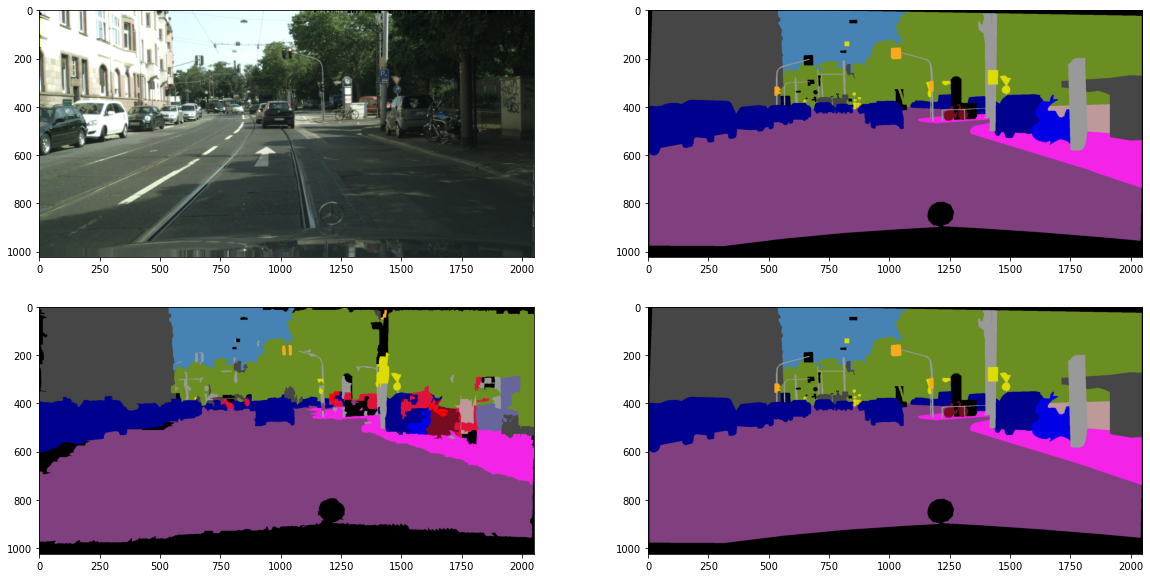

In [41]:
import matplotlib.pyplot as plt
from skimage.io import imshow

from random import *







pred_list = glob.glob(pred_path+'/*')
i = randint(1, len(pred_list)) 
# i=0
fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(2,2,1)
ax1 = fig.add_subplot(2,2,2)
ax2 = fig.add_subplot(2,2,3)
ax3 = fig.add_subplot(2,2,4)
pred_img_path = pred_list[i]

# clrEnc = UAVidColorTransformer()
pred_img = np.load(pred_img_path)

# uavid patch
# pred_seq = pred_img_path.split('/')[-1].split('_')[0]
# pred_patch = pred_img_path.split('/')[-1].split('_')[1]
# pred_num = pred_img_path.split('/')[-1].split('_')[2]
# gt_path = '../data/uavid/uavid_val_patch(1024)/'+ pred_seq + '/Labels/' + pred_patch+'_'+pred_num
# gt_img = imread(gt_path.replace('npy','png'))

# uavid full
# pred_seq = pred_img_path.split('/')[-1].split('_')[0]
# pred_num = pred_img_path.split('/')[-1].split('_')[1]
# gt_path = '../data/uavid/uavid_val/'+ pred_seq + '/Labels/' + pred_num
# gt_img = imread(gt_path.replace('npy','png'))
# gt_img = clrEnc.transform(gt_img, dtype=np.uint8)

# ciry
print(pred_img_path)
city= pred_img_path.split('/')[-1].split('_')[1]
num1 = pred_img_path.split('/')[-1].split('_')[2]
num2 = pred_img_path.split('/')[-1].split('_')[3]
gt_path = f'../data/city/gt/val/{city}/{city}_{num1}_{num2}_gtFine_color.png'
# gt_path = f'../data/city/gt/val/{city}/{city}_{num1}_{num2}_gtFine_labelIds.png'
# gt_img = imread(gt_path.replace('npy','png'))
gt_img = imread(gt_path)



print(gt_img.shape)
# gt_img = clrEnc.inverse_transform(gt_img)
# pred_img = clrEnc.inverse_transform(pred_img)


pred_img = inverse_transform(pred_img)
img_path = gt_path.replace('gtFine_color','leftImg8bit').replace('gt','img')
img = imread(img_path)

label = imread(gt_path.replace('color','labelIds'))
label = encode_labels(label)
label = inverse_transform(label)


ax0.imshow(img)
ax1.imshow(gt_img)
ax2.imshow(pred_img)
ax3.imshow(label)


plt.show()
# intersection , union = intersectionAndUnion(pred_img, label , 20)
# print(intersection/union)
